# Pitching Airfoil 

In [2]:
import jax.numpy as jnp
import numpy as np
import jax
import matplotlib.pyplot as plt
from jax import grad, jit, vmap
from typing import Callable
from functools import partial
from jax import lax
from scipy.integrate import solve_ivp
from time import time

# Dynamical Systems

In [3]:
class DynamicalSystem:
    # This class is the base class for all dynamical elements
    def __init__(self) -> None:
        raise NotImplementedError
    
    def jacobian(self, t: float, x: jnp.ndarray) -> jnp.ndarray:
        raise NotImplementedError

    def __call__(self, t: float, x: jnp.ndarray) -> jnp.ndarray:
        raise NotImplementedError

class LinearSystem(DynamicalSystem):
    def __init__(self, A: jnp.ndarray, B: jnp.ndarray) -> None:
        self.A = A
        self.B = B

    def jacobian(self, t: float, x: jnp.ndarray) -> jnp.ndarray:
        return self.A

    @partial(jit, static_argnums=(0,))
    def __call__(self, t: float, x: jnp.ndarray) -> jnp.ndarray:
        return self.A.squeeze() @ x + self.B

class NonLinearSystem(DynamicalSystem):
    def __init__(self,
         f: Callable[[float, jnp.ndarray], jnp.ndarray],
         jac: Callable[[float, jnp.ndarray], jnp.ndarray] | None = None
        ) -> None:
        self.f = jit(f)
        self.jac = jit(jac) if jac is not None else None 
    
    @partial(jit, static_argnums=(0,))
    def jacobian(self, t: float, x: jnp.ndarray) -> jnp.ndarray:
        if self.jac is not None:
            return self.jac(t,x)
        return jax.jacobian(self.f, argnums=1)(t,x)

    @partial(jit, static_argnums=(0,))
    def linearize(self,  t: float, x: jnp.ndarray) -> tuple[jnp.ndarray, jnp.ndarray]:
        A = self.jacobian(t,x)
        B = self.f(t,x) - A.squeeze() @ x
        return A, B
    
    @partial(jit, static_argnums=(0,))
    def __call__(self, t: float, x: jnp.ndarray) -> jnp.ndarray:
        # Linearize the system first and then use the linearized system to get the output
        linearized: LinearSystem = LinearSystem(*self.linearize(t,x))
        return linearized(t,x)

# Integrators

In [33]:
class Integrator:
    def __init__(self, system: DynamicalSystem) -> None:
        self.name = None
        self.type = None
        raise NotImplementedError

    def step(self, t: float, x: jnp.ndarray) -> jnp.ndarray:
        raise NotImplementedError
    
    def simulate(self, x0: jnp.ndarray, t0: float, tf: float) -> tuple[jnp.ndarray, jnp.ndarray]:
        raise NotImplementedError
    
class ForwardEulerIntegrator(Integrator):
    def __init__(self, dt: float, system: DynamicalSystem) -> None:
        self.name = "Forward Euler"
        self.type = "Explicit"
        self.dt = dt
        self.system = system

    @partial(jit, static_argnums=(0,))
    def step(self, t: float, x: jnp.ndarray) -> jnp.ndarray:
        return x + self.dt * self.system(t,x)
    
    def simulate(self, x0: jnp.ndarray, t0: float, tf: float) -> tuple[jnp.ndarray, jnp.ndarray]:
        num_steps = jnp.ceil((tf - t0) / self.dt).astype(int)
        # Preallocate the trajectory array
        trajectory = jnp.zeros((num_steps + 1, x0.shape[0]))
        trajectory = trajectory.at[0].set(x0)

        times = np.linspace(start= t0, stop = tf, num = num_steps + 1)
        times, trajectory = self._simulate(trajectory, times, num_steps)
        return times, trajectory

    @partial(jit, static_argnums=(0,))
    def _simulate(self, trajectory: jnp.ndarray, times: jnp.ndarray, num_steps: int) -> tuple[jnp.ndarray, jnp.ndarray]:
        # Create a loop using lax.fori_loop that integrates the system using the forward Euler method and
        # stores the results in the trajectory array
        def body(i, args):
            times, trajectory = args
            x = trajectory[i - 1]
            t = times[i - 1]
            step = self.step(t + i * self.dt, x)
            trajectory = trajectory.at[i].set(step)
            return times, trajectory
        
        times, trajectory = lax.fori_loop(1, num_steps + 1, body, (times, trajectory))
        return times, trajectory

class BackwardEulerIntegrator(Integrator):
    def __init__(self, dt: float, system: DynamicalSystem, max_iter: int = 1000, tol: float = 1e-6) -> None:
        self.name = "Backward Euler"
        self.type = "Implicit"
        self.dt: float = dt
        self.system = system
        # self.system -> f(t,x)
        # self.system.jacobian -> jacobian: df(t,x)/dx 
        self.max_iter = max_iter
        self.tol = tol

    @partial(jit, static_argnums=(0,))
    def step(self,t: float, x: jnp.ndarray) -> jnp.ndarray:
        # Initial guess for the solution
        x_new = x + self.dt * self.system(t,x)
        # Define the loop body
        def body(args):
            iteration, x_new, x_old= args
            
            # Calculate the update using the backward Euler method
            x_old = x_new
            # x_new = jnp.linalg.solve(jnp.eye(x.shape[0]) - self.dt * self.system(t,x_new), x + self.dt * self.system(t,x_new))
            x_new = jnp.linalg.solve(jnp.eye(x.shape[0]) - self.dt * self.system.jacobian(t,x_new)@(x_new - x), x + self.dt * self.system(t,x))
            iteration += 1
            return iteration, x_new, x_old
        
        def cond(args):
            iteration, x_new, x_old = args
            return (jnp.max(jnp.abs(x_new - x_old)) >= self.tol) & (iteration < self.max_iter)
        
        # Loop until convergence using lax.while_loop
        iterations, x_new, _  = lax.while_loop(cond,body,(0,x_new, jnp.zeros_like(x_new)))
        return x_new

    def simulate(self, x0: jnp.ndarray, t0: float, tf: float) -> tuple[jnp.ndarray, jnp.ndarray]:
        num_steps = jnp.ceil((tf - t0) / self.dt).astype(int)
        
        trajectory = jnp.zeros((num_steps + 1, x0.shape[0]))
        trajectory = trajectory.at[0].set(x0)
        times = np.linspace(start= t0, stop = tf, num = num_steps + 1)
        return self._simulate(trajectory, times, num_steps)

    @partial(jit, static_argnums=(0,))
    def _simulate(self, trajectory: jnp.ndarray, times: jnp.ndarray, num_steps: int) -> tuple[jnp.ndarray, jnp.ndarray]:
        # Create a loop using lax.fori_loop that integrates the system using the backward Euler method and
        # stores the results in the trajectory array
        def body(i, args):
            times, trajectory = args
            t = times[i - 1] + self.dt
            x = trajectory[i - 1]
            trajectory = trajectory.at[i].set(self.step(t, x))
            return times,trajectory

        times, trajectory = lax.fori_loop(1, num_steps + 1, body, (times, trajectory))
        return times ,trajectory

class RK4Integrator(Integrator):
    def __init__(self, dt: float, system):
        self.name = "RK4"
        self.type = "Explicit"
        self.dt = dt
        self.system = system

    @partial(jit, static_argnums=(0,))
    def step(self, t: float, x: jnp.ndarray) -> jnp.ndarray:
        k1 = self.system(t,x)
        k2 = self.system(t + self.dt / 2, x + (self.dt / 2) * k1)
        k3 = self.system(t + self.dt / 2, x + (self.dt / 2) * k2)
        k4 = self.system(t + self.dt, x + self.dt * k3)
        
        return x + (self.dt / 6) * (k1 + 2 * k2 + 2 * k3 + k4)
    
    def simulate(self, x0: jnp.ndarray, t0: float, tf: float) -> tuple[jnp.ndarray, jnp.ndarray]:
        num_steps = jnp.ceil((tf - t0) / self.dt).astype(int)
        x = x0
        t = t0
        trajectory = jnp.zeros((num_steps + 1, x0.shape[0]))
        trajectory = trajectory.at[0].set(x0)

        times = np.linspace(start=t0, stop=tf, num=num_steps + 1)
        return self._simulate(trajectory, times, num_steps)
    
    @partial(jit, static_argnums=(0,))
    def _simulate(self, trajectory: jnp.ndarray, times: jnp.ndarray, num_steps: int) -> tuple[jnp.ndarray, jnp.ndarray]:
        # Create a loop using lax.fori_loop that integrates the system using the RK4 method and
        # stores the results in the trajectory array
        def body(i, args):
            times, trajectory = args
            x = trajectory[i - 1]
            t = times[i - 1]
            trajectory = trajectory.at[i].set(self.step(t + i * self.dt,x))
            return times,trajectory
        
        times, trajectory = lax.fori_loop(1, num_steps + 1, body, (times, trajectory))
        return times, trajectory

class RK45Integrator(Integrator):
    """
    This class implements the Runge-Kutta Fehlberg 4(5) method for solving ODEs
    RK45 is a 5th order method with an embedded 4th order method for error estimation
    """
    def __init__(self, dt: float, system):
        self.name = "RK45"
        self.type = "Explicit"
        self.dt = dt
        self.system = system

    @partial(jit, static_argnums=(0,))
    def step(self,t: float, x: jnp.ndarray, dt: float) -> tuple[jnp.ndarray, float]:
        # Implement the Runge-Kutta Fehlberg 4(5) method
        tol = 1e-6

        k1 = self.system(t, x)
        k2 = self.system(t + (1/4) * dt, x + (1/4) * dt * k1)
        k3 = self.system(t + (3/8) * dt, x + (3/32) * dt * k1 + (9/32) * dt * k2)
        k4 = self.system(t + (12/13) * dt, x + (1932/2197) * dt * k1 - (7200/2197) * dt * k2 + (7296/2197) * dt * k3)
        k5 = self.system(t + dt, x + (439/216) * dt * k1 - 8 * dt * k2 + (3680/513) * dt * k3 - (845/4104) * dt * k4)
        k6 = self.system(t + (1/2) * dt, x - (8/27) * dt * k1 + 2 * dt * k2 - (3544/2565) * dt * k3 + (1859/4104) * dt * k4 - (11/40) * dt * k5)

        # Compute the 4th and 5th order estimates
        x_4 = x + (25/216) * dt * k1 + (1408/2565) * dt * k3 + (2197/4104) * dt * k4 - (1/5) * dt * k5
        x_5 = x + (16/135) * dt * k1 + (6656/12825) * dt * k3 + (28561/56430) * dt * k4 - (9/50) * dt * k5 + (2/55) * dt * k6

        # Compute the error
        error = jnp.abs(x_5 - x_4)

        # Adjust step size based on error
        delta = 0.84 * (tol / jnp.max(error))**0.25
        delta = jnp.clip(delta, 0.1, 1.1)
        dt = dt * delta
        return x_4, dt

        
    def simulate(self, x0: jnp.ndarray, t0: float, tf: float) -> tuple[jnp.ndarray, jnp.ndarray]:
        times, trajectory = self._simulate(x0, t0, tf)        
        return times, trajectory

    def _simulate(self, x0: jnp.ndarray, t0: float, tf: float) -> tuple[jnp.ndarray, jnp.ndarray]:
        # Create a loop using lax.while that integrates the system using the RK45 method and
        # stores the results in the trajectory array

        # Preallocate the trajectory array
        # Since we don't know the number of steps, we will use a python list to store the trajectory
        trajectory = [x0]
        times = [t0]
        x = x0
        dt = self.dt
        t = t0
        itera = 0

        while t < tf:
            x, dt = self.step(t,x, dt)
            t += dt
            trajectory.append(x)
            times.append(t)      
            itera += 1
        
        return jnp.array(times), jnp.array(trajectory)
    
class GaussLegendreIntegrator(Integrator):
    def __init__(self, dt: float, system: DynamicalSystem, tol: float = 1e-6, max_iter: int = 1000, damping: float = 1, n: int = 4) -> None:
        self.name = "Gauss-Legendre"
        self.type = "Implicit"
        self.dt = dt
        self.system = system
        self.tol = tol
        self.max_iter = max_iter
        # Check damping value
        if damping > 1 or damping <= 0:
            raise ValueError("Damping should be between 0 and 1.")
        self.damping = damping

        # Number of Gauss-Legendre nodes and weights
        self.n = n
        self.nodes, self.weights = np.polynomial.legendre.leggauss(self.n)


    @partial(jit, static_argnums=(0,))
    def step(self, t: float, x: jnp.ndarray) -> jnp.ndarray:
        d = x.shape[0]  # Get the dimension of the state vector

        # Use explicit Euler steps as initial guesses
        k1 = self.system(t, x)

        x1_guess = x + (1 / 2 - jnp.sqrt(3) / 6) * self.dt * k1
        k2 = self.system(t, x1_guess)
        a11 = 1 / 4
        a12 = 1 / 4 - jnp.sqrt(3) / 6
        a21 = 1 / 4 + jnp.sqrt(3) / 6
        a22 = 1 / 4

        def error(k1, k2):
            """Calculates the error for the current state estimates."""
            predicted_state1 = x + (a11 * self.dt * k1 + a12 * self.dt * k2)
            predicted_state2 = x + (a21 * self.dt * k1 + a22 * self.dt * k2)
            return jnp.concatenate([k1 - self.system(t, predicted_state1), k2 - self.system(t, predicted_state2)])

        def cond_fun(args):
            iteration, k1, k2 = args
            er = error(k1, k2)
            return (jnp.linalg.norm(er) > self.tol) & (iteration < self.max_iter)

        def body_fun(args):
            iteration, k1, k2 = args
            er = error(k1, k2)
            j1 = self.system.jacobian(t, x + (a11 * self.dt * k1 + a12 * self.dt * k2))
            j2 = self.system.jacobian(t, x + (a21 * self.dt * k1 + a22 * self.dt * k2))

            j = jnp.block([
                [jnp.eye(d) - self.dt * a11 * j1, -self.dt * a12 * j1],
                [-self.dt * a21 * j2, jnp.eye(d) - self.dt * a22 * j2]
            ])

            k_next = jnp.concatenate([k1, k2]) - self.damping * jnp.linalg.solve(j, er)
            k1 = k_next[:d]
            k2 = k_next[d:]

            return iteration + 1, k1, k2

        iteration, k1, k2 = lax.while_loop(cond_fun, body_fun, (0, k1, k2))
        x_next = x + self.dt / 2 * (k1 + k2)
        return x_next

        # x_guess = [x + self.dt * self.nodes[i] * k1 for i in range(self.n)]
        # ks = [self.system(t + self.dt * self.nodes[i], x_guess[i]) for i in range(self.n)]
        # ks = jnp.array(ks)

        # coefficients = jnp.array([[(self.weights[i] / 2) * (self.dt * (1 + self.nodes[i])) for i in range(self.n)],
        #                           [(self.weights[i] / 2) * (self.dt * (1 - self.nodes[i])) for i in range(self.n)]])

        # def error(ks):
        #     """Calculates the error for the current state estimates."""
        #     predicted_states = [x + sum(coefficients[j][i] * self.dt * ks[i] for i in range(self.n)) for j in range(2)]
        #     return jnp.concatenate([ks[j] - self.system(t, predicted_states[j]) for j in range(2)])
        
        # def cond_fun(args):
        #     iteration, ks = args
        #     er = error(ks)
        #     return (jnp.linalg.norm(er) > self.tol) & (iteration < self.max_iter)
        
        # def body_fun(args):
        #     iteration, ks = args
        #     er = error(ks)

        #     # Calculate Jacobian matrix
        #     jacobians = [self.system.jacobian(t, x + jnp.dot(coefficients[j], ks) * self.dt) for j in range(2)]
            
        #     # Construct the Jacobian matrix
        #     eye_block = jnp.eye(d)
        #     jac_upper = eye_block - jnp.sum(self.dt * coefficients[0][:, None, None] * jacobians[0], axis=0)
        #     jac_lower = -jnp.sum(self.dt * coefficients[1][:, None, None] * jacobians[1], axis=0)

        #     jac = jnp.vstack([jac_upper, jac_lower])

        #     ks_next = ks - self.damping * jnp.linalg.solve(jac, er)

        #     return iteration + 1, ks_next

        # iteration, ks = lax.while_loop(cond_fun, body_fun, (0, ks))
        
        # # Calculate next state
        # x_next = x + sum(self.dt / 2 * self.weights[i] * (ks[0][i] + ks[1][i]) for i in range(self.n))
        
        # return x_next


    def simulate(self, x0: jnp.ndarray, t0: float, tf: float) -> tuple[jnp.ndarray, jnp.ndarray]:
        num_steps = jnp.ceil((tf - t0) / self.dt).astype(int)

        trajectory = jnp.zeros((num_steps + 1, x0.shape[0]))
        trajectory = trajectory.at[0].set(x0)
        times = jnp.linspace(start=t0, stop=tf, num=num_steps + 1)
        return self._simulate(trajectory, times, num_steps)
    
    @partial(jit, static_argnums=(0,))
    def _simulate(self, trajectory: jnp.ndarray, times: jnp.ndarray, num_steps: int) -> tuple[jnp.ndarray, jnp.ndarray]:
        # Create a loop using lax.fori_loop that integrates the system using the Gauss-Legendre method and
        # stores the results in the trajectory array
        def body(i, args):
            times, trajectory = args
            t = times[i - 1] + self.dt
            x = trajectory[i - 1]
            trajectory = trajectory.at[i].set(self.step(t, x))
            return times, trajectory

        times, trajectory = lax.fori_loop(1, num_steps + 1, body, (times, trajectory))
        return times, trajectory

# class CrankNicolsonIntegrator(Integrator):
#     def __init__(self, dt: float, system: DynamicalSystem, tol: float = 1e-6) -> None:
#         self.name = "Crank-Nicolson"
#         self.type = "Semi-Implicit"
#         self.dt = dt
#         self.system = system
#         self.tol = tol

#     @partial(jit, static_argnums=(0,))
#     def step(self, t: float, x: jnp.ndarray) -> jnp.ndarray:

#         def error(x1):
#             """Calculates the error for the current state estimate."""
#             k1 = self.system(t, x)
#             k2 = self.system(t + self.dt, x1)
#             predicted_state = x + 0.5 * self.dt * (k1 + k2)
#             return predicted_state - x - self.dt * self.system(t + 0.5 * self.dt, predicted_state)

#         def cond_fun(er):
#             """Loop condition based on error norm."""
#             return jnp.linalg.norm(er) > self.tol

#         def body_fun(x1):
#             """Iteratively solve for the full step solution."""
#             j = self.system.jacobian(t + 0.5 * self.dt, x1)
#             er = error(x1)
#             return x1 - jnp.linalg.solve(j, er)

#         x_next = lax.while_loop(cond_fun, body_fun, x + 0.5 * self.dt * self.system(t, x))

#         return x_next
  
#     def simulate(self, x0: jnp.ndarray, t0: float, tf: float) -> tuple[jnp.ndarray, jnp.ndarray]:
#         num_steps = jnp.ceil((tf - t0) / self.dt).astype(int)
    
#         trajectory = jnp.zeros((num_steps + 1, x0.shape[0]))
#         trajectory = trajectory.at[0].set(x0)
#         times = jnp.linspace(start=t0, stop=tf, num=num_steps + 1)
#         return self._simulate(trajectory, times, num_steps)
    
#     @partial(jit, static_argnums=(0,))
#     def _simulate(self, trajectory: jnp.ndarray, times: jnp.ndarray, num_steps: int) -> tuple[jnp.ndarray, jnp.ndarray]:
#         # Create a loop using lax.fori_loop that integrates the system using the Crank-Nicolson method and
#         # stores the results in the trajectory array
#         def body(i, args):
#             times, trajectory = args
#             t = times[i - 1] + self.dt
#             x = trajectory[i - 1]
#             trajectory = trajectory.at[i].set(self.step(t, x))
#             return times, trajectory

#         times, trajectory = lax.fori_loop(1, num_steps + 1, body, (times, trajectory))
#         return times, trajectory


# Simple Mass-Damper System

In [34]:
# Define a simple m-c-k system
m = 1.0
c = 0.1
k = 1.0


def f(t:float, x: jnp.ndarray) -> jnp.ndarray:
    return jnp.array([
        x[1],                            # x' = v
        -c /m * x[1] - k/m * x[0]        # v' = a = -c/m * v - k/m * x
    ])

# Create the system
system = NonLinearSystem(f)

# Create all the integrators
dt0 = 1e-2
integrator_rk4 = RK4Integrator(dt0, system)
integrator_feuler = ForwardEulerIntegrator(dt0, system)
integrator_beuler = BackwardEulerIntegrator(dt0, system)
integrator_rk45 = RK45Integrator(dt0, system)
integrator_gauss_legendre = GaussLegendreIntegrator(dt0, system, n = 4)
# integrator_crank_nicolson = CrankNicolsonIntegrator(dt0, system)


# Simulate the system
x0 = jnp.array([1.0, 0.0])
t0 = 0.0
t_end = 10000 * dt0

# Simulate the system using all the integrators
x_data = {}
t_data = {}

integrators = [
    integrator_feuler,
    # integrator_rk4,
    integrator_rk45,
    integrator_beuler,
    integrator_gauss_legendre,
    # integrator_crank_nicolson
]
for integrator in integrators:
    print(f"Simulating using {integrator.name} integrator")
    time_s = time()
    t_data[integrator.name], x_data[integrator.name] = integrator.simulate(x0, t0, t_end)
    time_e = time()
    print(f"\tSimulated using {integrator.name} integrator")
    print(f"\tTime taken: {time_e - time_s} seconds")

Simulating using Forward Euler integrator
	Simulated using Forward Euler integrator
	Time taken: 0.2190265655517578 seconds
Simulating using RK45 integrator
	Simulated using RK45 integrator
	Time taken: 0.5672621726989746 seconds
Simulating using Backward Euler integrator
	Simulated using Backward Euler integrator
	Time taken: 0.2437431812286377 seconds
Simulating using Gauss-Legendre integrator
	Simulated using Gauss-Legendre integrator
	Time taken: 0.3985753059387207 seconds


In [35]:
print("Simulating using scipy RK45")
time_s = time()
sol = solve_ivp(f, [t0, t_end], x0, method='BDF', t_eval=np.linspace(0, t_end, 1000),  rtol=1e-6, atol=1e-6)
t_data["scipy_rk45"] = sol.t
x_data["scipy_rk45"] = sol.y.T
time_e = time()
print(f"\tSimulated using scipy RK45")
print(f"\tTime taken: {time_e - time_s} seconds")

Simulating using scipy RK45
	Simulated using scipy RK45
	Time taken: 0.4428861141204834 seconds


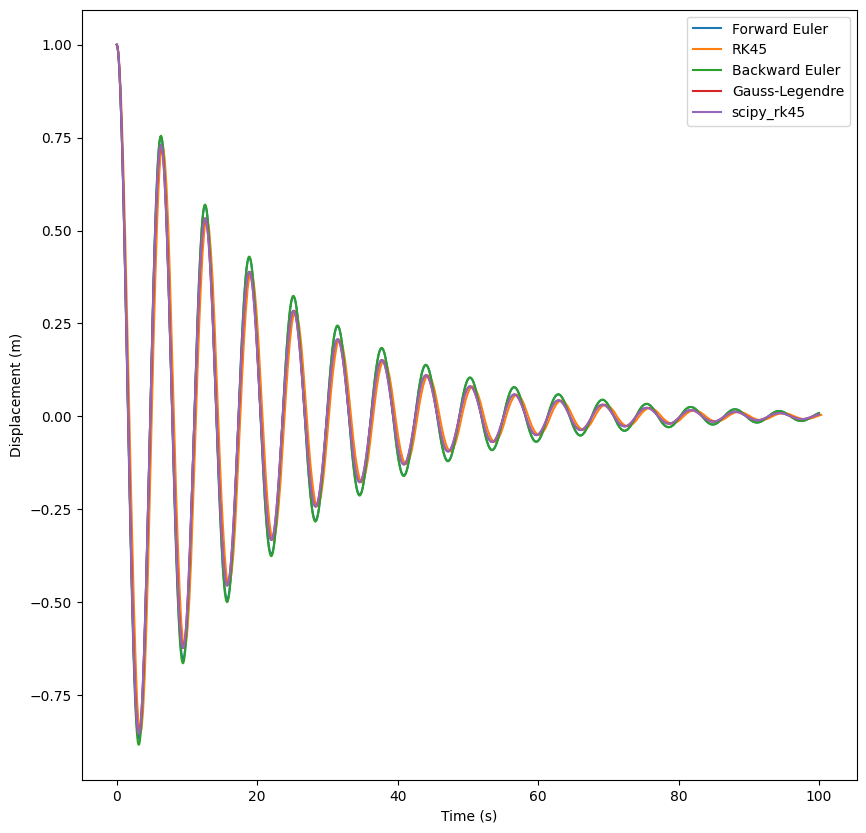

In [36]:
# Plot the results
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
for key in x_data.keys():
    # Compute cap so that we plot 1000 points at most
    cap = max(1, int(len(t_data[key]) / 1000))
    ax.plot(t_data[key][::cap], x_data[key][:,0][::cap], label=key)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Displacement (m)")
ax.legend()

plt.show()

# Second Order Systems

In [37]:
class SecondOrderSystem(DynamicalSystem):
    """
    This class is for second order systems of the form:
    M(u,t) u'' + C(u,t) u' + f_int(u,t) u = f_ext(u,t)
    """

    def __init__(
        self, 
        M: Callable[[float, jnp.ndarray], jnp.ndarray] | jnp.ndarray, 
        C: Callable[[float, jnp.ndarray], jnp.ndarray] | jnp.ndarray, 
        K: Callable[[float, jnp.ndarray], jnp.ndarray] | jnp.ndarray, 
        f_ext: Callable[[float, jnp.ndarray], jnp.ndarray] | jnp.ndarray = lambda t,u: jnp.zeros_like(u),
    ) -> None:

        if isinstance(M, jnp.ndarray):
            if M.shape == () or M.shape == (1,):
                M = M.reshape(-1, 1)
            self.M = jit(lambda t,x: M)
        else:
            self.M = lambda t,x: jit(M)

        if isinstance(C, jnp.ndarray):
            if C.shape == () or C.shape == (1,):
                C = C.reshape(-1, 1)
            self.C = jit(lambda t,x: C)
        else:
            self.C = jit(C)

        if isinstance(K, jnp.ndarray):
            if K.shape == () or K.shape == (1,):
                K = K.reshape(-1, 1)
            self.f_int = jit(lambda t,x: K)
        else:
            self.f_int = jit(K)

        if isinstance(f_ext, jnp.ndarray):
            if f_ext.shape == () or f_ext.shape == (1,):
                f_ext = f_ext.reshape(-1, 1)
            f_ext_fun = lambda t,x: f_ext
        else:
            f_ext_fun = f_ext
            
        # Wrap F_ext in order to make sure it returns a column vector of the same size as u
        def f_ext_wrapped(t: float, x: jnp.ndarray) -> jnp.ndarray:
            return f_ext_fun(t,x).reshape(-1, 1)
        
        self.f_ext = jit(f_ext_wrapped)

    @partial(jit, static_argnums=(0,))
    def jacobian(self, t: float, x: jnp.ndarray) -> jnp.ndarray:
        return jax.jacobian(self.__call__, argnums=0)(t,x)


    def convert_to_first_order(self) -> NonLinearSystem:
        return NonLinearSystem(f = self.__call__)

    @partial(jit, static_argnums=(0,))    
    def __call__(self, t: float, x: jnp.ndarray) -> jnp.ndarray:
        # Convert system to a first order system of ODEs by defining the state as [u, v]
        # Then the output is given by:
        # x' = [

        #           v,
        #           M^-1 @ (f_ext - f_int @ u - C @ v)
        #      ]
        # where u is the displacement and v is the velocity of the system
        # and M is the mass matrix, C is the damping matrix, f_int is the internal force and f_ext is the external force
        # The mass matrix M, damping matrix C, internal force f_int and external force f_ext are all functions of time and the state x
        # The state x is a column vector of size 2n where n is the size of the state
        # The first n elements of x represent the displacement u and the second n elements represent the velocity v
        
        n = x.shape[0] // 2  # Half the size for each part of the state
        u = x[:n].reshape(-1, 1).squeeze()  # First half represents u (displacement), reshape to column vector
        v = x[n:].reshape(-1, 1).squeeze()  # Second half represents v (velocity), reshape to column vector

        M = self.M(t, x)
        C = self.C(t, x)
        f_int = self.f_int(t, x)
        f_ext = self.f_ext(t, x).squeeze()

        # If the mass matrix is a scalar, then we can't use the inverse
        if isinstance(M, jnp.ndarray):
            if M.shape == () or M.shape == (1,) or M.shape == (1, 1):
                a = (f_ext - f_int * u - C * v) / M  # Solve for the acceleration
                a = jnp.array(a).reshape(-1, 1)
            else:
                a = jnp.linalg.solve(M, f_ext - f_int @ u - C @ v).squeeze()  # Solve for the acceleration
        else:
            raise ValueError("Mass matrix M must be a square matrix")
        return jnp.concatenate([v, a], axis=0).squeeze()
    
    @partial(jit, static_argnums=(0,))
    def linearize(self,  t: float, x: jnp.ndarray) -> tuple[jnp.ndarray, jnp.ndarray]:
        A = self.jacobian(t,x)
        B = self(t,x) - A.squeeze() @ x
        return A, B

In [38]:
class NewmarkIntegrator:
    def __init__(self, dt: float, system: SecondOrderSystem, gamma: float = 0.5, beta: float = 0.25):
        self.name = "Newmark"
        self.type = "Implicit"
        self.dt = dt
        self.system = system
        self.gamma = gamma
        self.beta = beta

    @partial(jit, static_argnums=(0,))
    def step(
        self, 
        u_old: jnp.ndarray, 
        v_old: jnp.ndarray, 
        a_old:jnp.ndarray, 
        t: float
    ) -> tuple[jnp.ndarray, jnp.ndarray, jnp.ndarray]:
        M = self.system.M(t, jnp.concatenate([u_old, v_old]))
        C = self.system.C(t, jnp.concatenate([u_old, v_old]))
        K = self.system.f_int(t, jnp.concatenate([u_old, v_old]))
        f_ext = self.system.f_ext(t, jnp.concatenate([u_old, v_old])).squeeze()
        
        # Calculate predictors
        u_new = u_old + self.dt * v_old + (0.5 - self.beta) * self.dt**2 * a_old
        v_new = v_old + (1 - self.gamma) * self.dt * a_old

        # Solve the linear proble Ax = b
        # print the shapes of the matrices
        a_new = jnp.linalg.solve(
            M + self.gamma * self.dt * C + self.beta * self.dt**2 * K,
            f_ext - K @ u_new - C @ v_new
        )
        # Calculate Correctors
        u_new += self.beta * self.dt**2 * a_new
        v_new += self.gamma * self.dt * a_new
        return u_new, v_new, a_new

    def simulate(self, x0: jnp.ndarray, t0: float, tf: float) -> tuple[jnp.ndarray, jnp.ndarray]:
        num_steps = jnp.ceil((tf - t0) / self.dt).astype(int)
        trajectory = jnp.zeros((num_steps + 1, x0.shape[0]))
        trajectory = trajectory.at[0].set(x0)
        times = np.linspace(t0, tf, num_steps + 1)

        # Split function into two parts
        # return self._simulate(trajectory, times, num_steps)
        # @partial(jit, static_argnums=(0,))
        # def _simulate(self, trajectory: jnp.ndarray, times: jnp.ndarray, num_steps: int) -> tuple[jnp.ndarray, jnp.ndarray]:
        
        # Simulate the system using the Newmark integrator
        # using lax.fori_loop
        def body(i, args):
            times, trajectory, accelaration = args

            u_old = trajectory[i - 1][:x0.shape[0] // 2].squeeze()
            v_old = trajectory[i - 1][x0.shape[0] // 2:].squeeze()
            t = times[i - 1]

            u_new, v_new, accelaration = self.step(u_old, v_old, accelaration, t)
            # squeeze the results
            u_new = u_new.squeeze()
            v_new = v_new.squeeze()
            accelaration = accelaration.squeeze()
            x_new = jnp.hstack([u_new, v_new]).squeeze()
            trajectory = trajectory.at[i].set(x_new)
            return times, trajectory, accelaration
        
        a0 = jnp.zeros_like(x0[:x0.shape[0] // 2]).squeeze()
        times, trajectory, _ = lax.fori_loop(1, num_steps + 1, body, (times, trajectory, a0))
        return times, trajectory


In [39]:
# Define a 2nd order system 
m1 = 1.0
c1 = 0.1
k1 = 1.0

m2 = 1.0
c2 = 0.1
k2 = 1.0

M = jnp.array(
    [
        [m1, 0],
        [0, m2]
    ])
# M = jnp.array([m])
C = jnp.array(
    [
        [c1, 0],
        [0, c2]
    ])
# C = jnp.array([c])
f_int = jnp.array(
    [
        [k1, -k1],
        [-k1, k1 + k2]
    ])
# f_int = jnp.array([k])

def f_ext(t: float, x: jnp.ndarray) -> jnp.ndarray:
    return jnp.array(
        [0.0, jnp.sin(t)]
    )
# f_ext = lambda t, x: jnp.array([0.0])

system = SecondOrderSystem(M, C, f_int, f_ext)
system2 = system.convert_to_first_order()

In [40]:
dt0 = 1e-3
t0 = 0.0
t_end = 50

u0 = jnp.array([1.0, 0.0])
v0 = jnp.array([0.0, 0.0])
x0 = jnp.hstack([u0, v0])

# Simulate the system using the Newmark integrator
newmark_integrator = NewmarkIntegrator(dt0, system)
print(f"Simulating using {newmark_integrator.name} integrator")
time_s = time()
t, x_old = newmark_integrator.simulate(x0, t0, t_end)
time_e = time()
print(f"\tSimulated using {newmark_integrator.name} integrator")
print(f"\tTime taken: {time_e - time_s} seconds")

# Simulate the system using the Backward Euler integrator
feuler_integrator = ForwardEulerIntegrator(dt0, system2)
print(f"Simulating using {feuler_integrator.name} integrator")
time_s = time()
t2, x2 = feuler_integrator.simulate(x0, t0, t_end)
time_e = time()
print(f"\tSimulated using {feuler_integrator.name} integrator")
print(f"\tTime taken: {time_e - time_s} seconds")

# Simulate the system using the backward Euler integrator 
rk45_integrator = RK45Integrator(dt0, system2)
print(f"Simulating using {rk45_integrator.name} integrator")
time_s = time()
t3, x3 = rk45_integrator.simulate(x0, t0, t_end)
time_e = time()
print(f"\tSimulated using {rk45_integrator.name} integrator")
print(f"\tTime taken: {time_e - time_s} seconds")

beuler_integrator = BackwardEulerIntegrator(dt0, system2)
print(f"Simulating using {beuler_integrator.name} integrator")
time_s = time()
t4, x4 = beuler_integrator.simulate(x0, t0, t_end)
time_e = time()
print(f"\tSimulated using {beuler_integrator.name} integrator")
print(f"\tTime taken: {time_e - time_s} seconds")

Simulating using Newmark integrator
	Simulated using Newmark integrator
	Time taken: 0.3064587116241455 seconds
Simulating using Forward Euler integrator
	Simulated using Forward Euler integrator
	Time taken: 0.3515918254852295 seconds
Simulating using RK45 integrator
	Simulated using RK45 integrator
	Time taken: 1.505967378616333 seconds
Simulating using Backward Euler integrator
	Simulated using Backward Euler integrator
	Time taken: 0.681736946105957 seconds


In [42]:
# Integrate using scipy RK45
print("Simulating using scipy RK45")
time_s = time()
sol = solve_ivp(system, [t0, t_end], x0, method='RK45', t_eval=np.linspace(t0, t_end, 1000), rtol=1e-6, atol=1e-6)
t5 = sol.t
x5 = sol.y.T
time_e = time()
print(f"\tSimulated using scipy RK45")
print(f"\tTime taken: {time_e - time_s} seconds")

Simulating using scipy RK45
	Simulated using scipy RK45
	Time taken: 0.40708231925964355 seconds


Plotting Newmark integrator
Number of points: 1000
Plotting Forward Euler integrator
Number of points: 50001
Plotting RK45 integrator
Number of points: 340
Plotting Backward Euler integrator
Number of points: 50001
Plotting scipy RK45 integrator
Number of points: 1000


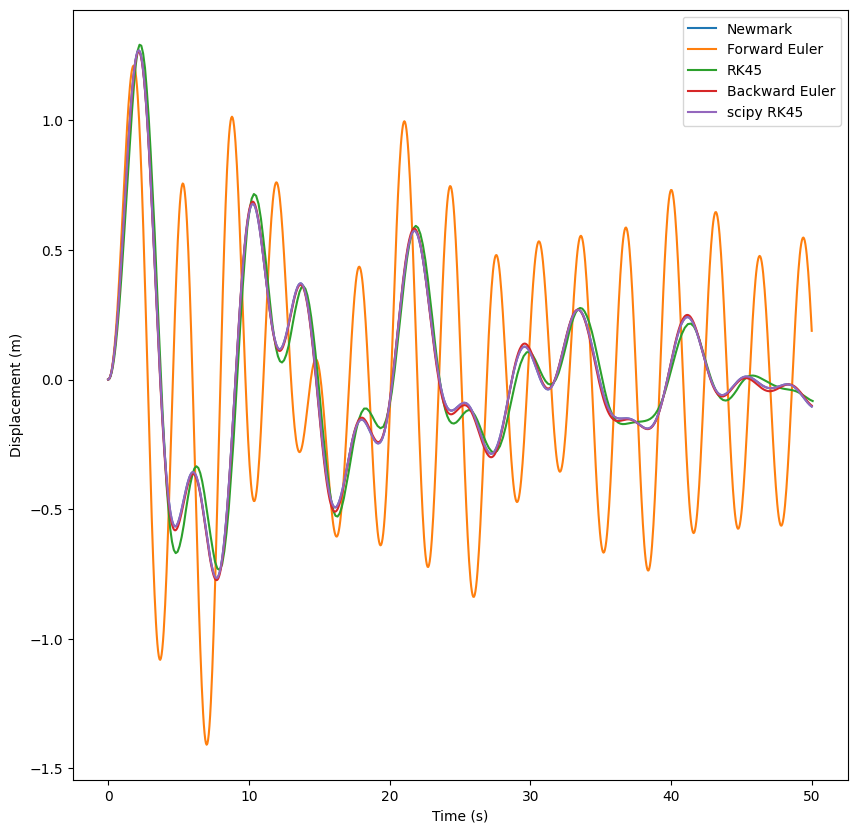

In [45]:
# Plot the results
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
# IF the array is too large, we can plot every 100th point
for key, value in zip(
    [newmark_integrator.name, feuler_integrator.name, rk45_integrator.name, beuler_integrator.name, "scipy RK45"],
    [(t,x_old), (t2,x2), (t3,x3), (t4,x4), (t5,x5)]
):
    t,x_old = value
    print(f"Plotting {key} integrator")
    print(f"Number of points: {len(t)}")
    cap = max(1, int(len(t) / 1000))
    # ax.plot(t[::cap], x_old[:,0][::cap], label=key)
    ax.plot(t[::cap], x_old[:,1][::cap], label=key)
    ax.set_xlabel("Time (s)")
ax.legend()
ax.set_xlabel("Time (s)")
ax.set_ylabel("Displacement (m)")
ax.legend()